<a href="https://colab.research.google.com/github/urbinaticri/GraphNeuralNetworks/blob/main/Parametrized_GAT_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
!pip install torch-geometric

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [242]:
import networkx as nx
from torch_geometric.utils import to_networkx

import tqdm
import time
import math
import random
import torch
import torch.nn.functional as F
import torch.utils.data as data_utils
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

from sklearn.manifold import TSNE

We also check if gpu is available, in this way we will be able to perform training faster

In [4]:
device = 'cpu'
if torch.cuda.is_available:
  print('All good, a Gpu is available')
  device = torch.device("cuda:0")  
else:
  print('Please set GPU via Edit -> Notebook Settings.')
  

All good, a Gpu is available


In [5]:
!nvidia-smi

Sat Apr  2 09:13:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Reproducibility
When **developing and debugging** Neural Networks is desirable to have a deterministic behaviour. For this reason, we are going to disable all the sources of randomness. Please note that completely reproducible results are not guaranteed across PyTorch releases, individual commits or different platforms. You can find more detailed information at this [page](https://pytorch.org/docs/stable/notes/randomness.html).
Please note that the flag `cudnn.benchmark = False` disable the auto-tuner that selects the optimal set of algorithms for your hardware and usually leads to slower runtime. 

In [6]:
def fix_random(seed: int) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True        

In [7]:
fix_random(42)

## The dataset
The datasets we will use in the experiments are the ones offered by torch_geometrics, we can explore the list in that [page](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets).

We will also visualize the data and perform some analysis and statistics about their distribution to see if some network structures works better in some scenarios with respect tot other.

In [60]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
dataset = Planetoid(root=".", name="PubMed", split="full", transform=NormalizeFeatures())

In [61]:
print()
print(f'Dataset: {dataset}:')
print('==================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===============================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.3f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: PubMed():
Number of graphs: 1
Number of features: 500
Number of classes: 3

Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])
Number of nodes: 19717
Number of edges: 88648
Average node degree: 4.50
Number of training nodes: 18217
Training node label rate: 0.924
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Let's see if class are balanced or not across the splits:

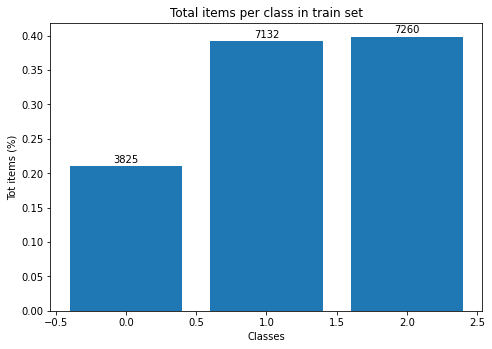

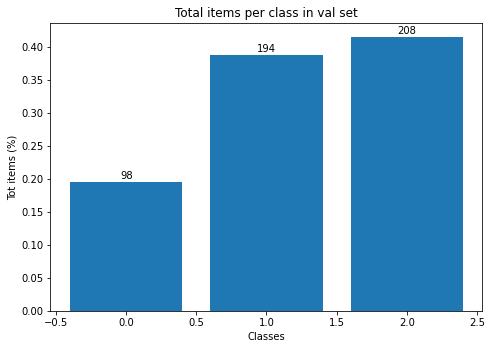

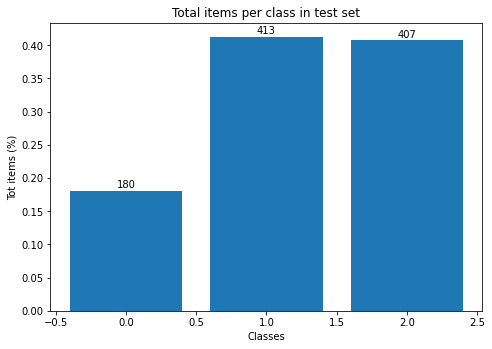

In [12]:
def plot_total_per_class(dataset, split):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    classes = [c for c in range(dataset.num_classes)]
    totals = [0 for c in range(dataset.num_classes)]

    for i in range(len(dataset)):
        graph = dataset[i]
        split_mask = {
        'train' : graph.train_mask,
        'val': graph.val_mask,
        'test': graph.test_mask,
        }
        items = [graph.y[split_mask[split]].tolist().count(i) for i in classes ]
        totals = [x + y for x, y in zip(totals, items)]

    normalized_totals = [float(x) / np.sum(totals) for x in totals]
    bars = ax.bar(classes, normalized_totals)

    for i, bar in enumerate(bars):
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval + .005, totals[i], ha='center')

    plt.xlabel('Classes')
    plt.ylabel('Tot items (%)')
    plt.title(f"Total items per class in {split} set")
    plt.show()

for split in ['train', 'val', 'test']:
    plot_total_per_class(dataset, split)

Let's plot the structure of the first graph in the dataset:

In [ ]:
G = to_networkx(data, to_undirected=True)
nx.draw(G, node_color=data.y, node_size=20)

# Model Definition

## GAT
Popular GNN architectures weigh all neighbors $j \in N_{i}$ with equal importance (e.g., mean or max-pooling as AGGREGATE). To
address this limitation, GAT computes a score
for every edge $(j, i)$, which indicates the importance of the features of the neighbor $j$ to the node $i$.

GAT convolution is matematically defined as:

$$ x_{i}^{'} = \alpha_{i,j} \Theta x_{i} + \sum_{j \in \mathcal{N}(i)} \alpha_{i,j} \Theta x_{j}$$

the scoring function is defined as:

$$ e(x_{i}, x_{j}) =  \text{LeakyReLU}(a^\top \cdot [\Theta x_{i} || \Theta x_{j}]) $$

and is used to compute the attention coefficients:

$$ \alpha_{i,j} = \text{softmax}_{j}(e(x_{i}, x_{j})) =  \frac{\exp(e(x_{i}, x_{j}))}{\sum_{j^{'} \in \mathcal{N}} \exp(e(x_{i}, x_{j^{'}}))} $$


The main problem in the standard GAT scoring function  is that the learned layers $\Theta$ and $a$ are applied consecutively, and thus can be collapsed into a single linear layer. To fix
this limitation, in GATv2 the $a$ layer is applied after the nonlinearity (LeakyReLU), and the $\Theta$ layer
after the concatenation, effectively applying an MLP to compute the score for each query-key pair:

$$ e(x_{i}, x_{j}) =  a^\top \text{LeakyReLU}(\Theta \cdot [x_{i} ||  x_{j}]) $$

In [239]:
from torch_geometric.nn.conv import GATv2Conv

In [243]:
from torch_geometric.nn.dense.linear import Linear

class ParametrizedGATNet(torch.nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, p_drop=0.5, n_layers=2, n_heads=3):
        super(ParametrizedGATNet, self).__init__()
        self.p_drop = p_drop
        self.convs = torch.nn.ModuleList()
        for i in range(1, n_layers):
            conv = GATv2Conv(in_dim, hid_dim, heads=n_heads, concat=True)
            self.convs.append(conv)
            in_dim = hid_dim * n_heads
        conv = GATv2Conv(in_dim, out_dim, heads=1, concat=False)
        self.convs.append(conv)

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs[:-1]):
            x = F.relu(conv(x, edge_index))
            x = F.dropout(x, p=self.p_drop, training=self.training)
        h = F.log_softmax(self.convs[-1](x, edge_index), dim=1)
        return h

**Cluster-GCN** ([Chiang et al. (2019)](https://arxiv.org/abs/1905.07953) works by first partioning the graph into subgraphs based on graph partitioning algorithms.
With this, GNNs are restricted to solely convolve inside their specific subgraphs, which omits the problem of **neighborhood explosion**.

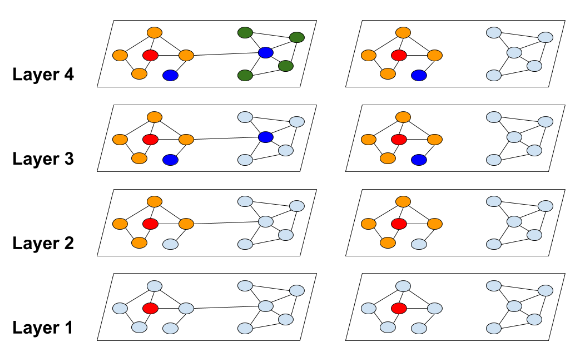

However, after the graph is partitioned, some links are removed which may limit the model's performance due to a biased estimation.
To address this issue, Cluster-GCN also **incorporates between-cluster links inside a mini-batch**, which results in the following **stochastic partitioning scheme**:

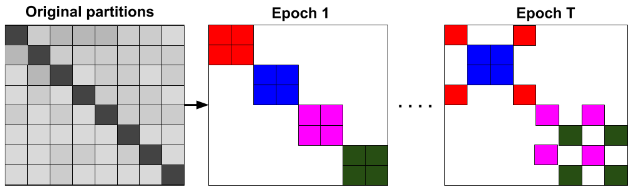

Here, colors represent the adjacency information that is maintained per batch (which is potentially different for every epoch).

PyTorch Geometric provides a **two-stage implementation** of the Cluster-GCN algorithm:
1. [**`ClusterData`**](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.ClusterData) converts a `Data` object into a dataset of subgraphs containing `num_parts` partitions.
2. Given a user-defined `batch_size`, [**`ClusterLoader`**](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.ClusterLoader) implements the stochastic partitioning scheme in order to create mini-batches.

The procedure to craft mini-batches then looks as follows:

In [244]:
from torch_geometric.loader import ClusterData, ClusterLoader

cluster_data = ClusterData(data, num_parts=128)  # 1. Create subgraphs.
train_loader = ClusterLoader(cluster_data, batch_size=32, shuffle=True)  # 2. Stochastic partioning scheme.

print()
total_num_nodes = 0
for step, sub_data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of nodes in the current batch: {sub_data.num_nodes}')
    print(sub_data)
    print()
    total_num_nodes += sub_data.num_nodes

print(f'Iterated over {total_num_nodes} of {data.num_nodes} nodes!')

Computing METIS partitioning...



Step 1:
Number of nodes in the current batch: 4959
Data(x=[4959, 500], y=[4959], train_mask=[4959], val_mask=[4959], test_mask=[4959], edge_index=[2, 19736])

Step 2:
Number of nodes in the current batch: 4942
Data(x=[4942, 500], y=[4942], train_mask=[4942], val_mask=[4942], test_mask=[4942], edge_index=[2, 16768])

Step 3:
Number of nodes in the current batch: 4892
Data(x=[4892, 500], y=[4892], train_mask=[4892], val_mask=[4892], test_mask=[4892], edge_index=[2, 15378])

Step 4:
Number of nodes in the current batch: 4924
Data(x=[4924, 500], y=[4924], train_mask=[4924], val_mask=[4924], test_mask=[4924], edge_index=[2, 15306])

Iterated over 19717 of 19717 nodes!


Done!


# Train and evaluate functions

The train function performs 10 trials resetting each time the model weights and running a training for 100 epochs, after each epoch a validation phase is performed. The metric used is the accuracy since the problem has balanced classes.

Early stopping is performed in order to prevent the model to overfit on train set, in particular, if the accuracy on validation set get worse cosecutively for more time than the patience the train is aborted.

The train funcion returns the weights of the best model alongside its corresponding history and embeddings.

The test function performs the evaluation of the model in terms of accuracy.

In [267]:
def train(model, optimizer, loss_fn, train_loader, trials=1, epochs=20, patience=5, device='cuda', verbose=2):

    if verbose > 1: print('Train: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    start_time_sec = time.time()

    best_model_weights = None
    best_model_history = None

    best_val_acc = 0

    for trial in range(trials):
        if verbose > 1: print(f'Trial n°{trial+1}:')
        model.reset_parameters()

        trigger_times = 0
        last_val_acc = 0

        history = {}
        history['loss'] = []
        history['val_loss'] = []
        history['acc'] = []
        history['val_acc'] = []

        embeddings = []

        
        iterator = tqdm.tqdm(range(epochs), desc = f'Trial n°{trial+1}') if verbose < 2 else range(epochs)
        for epoch in iterator:

            # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
            model.train()
            num_train_correct  = 0
            num_train_examples = 0

            for data in train_loader:
                train_loss_item = 0.0
                optimizer.zero_grad()

                yhat = model(data.x, data.edge_index)
                train_loss = loss_fn(yhat[data.train_mask], data.y[data.train_mask])
                train_loss_item = train_loss.item()

                train_loss.backward()
                optimizer.step()

            num_train_correct  += (torch.max(yhat[data.train_mask], 1)[1] == data.y[data.train_mask]).sum().item()
            num_train_examples += data.y[data.train_mask].shape[0]
            train_acc   = num_train_correct / num_train_examples

            embeddings.append(yhat)

            # --- EVALUATE ON VALIDATION SET -------------------------------------
            model.eval()
            val_loss_item       = 0.0
            num_val_correct  = 0
            num_val_examples = 0

            with torch.no_grad():
                yhat = model(data.x, data.edge_index)
                val_loss = loss_fn(yhat[data.val_mask], data.y[data.val_mask])
                val_loss_item = val_loss.item()

                num_val_correct  += (torch.max(yhat[data.val_mask], 1)[1] == data.y[data.val_mask]).sum().item()
                num_val_examples += data.y[data.val_mask].shape[0]

                val_acc  = num_val_correct / num_val_examples

            if verbose > 1 and ( (epoch + 1) % 10 == 0 or epoch == 0 ) :
                print('Epoch %3d/%3d, train loss: %5.2f, train acc: %5.2f, val loss: %5.2f, val acc: %5.2f' % \
                (epoch+1, epochs, train_loss_item, train_acc, val_loss_item, val_acc))

            history['loss'].append(train_loss_item)
            history['val_loss'].append(val_loss_item)
            history['acc'].append(train_acc)
            history['val_acc'].append(val_acc)

            

            # Early stopping
            if history['val_acc'][-1] < last_val_acc:
                trigger_times += 1
                if trigger_times >= patience:
                    if verbose > 1: print('Early stopping: stop training')
                    else: 
                        iterator.update(epochs - iterator.n) 
                        iterator.close()            
                    break
            else:
                trigger_times = 0
                last_val_acc = history['val_acc'][-1]
            
                if last_val_acc > best_val_acc:
                    best_model_weights = model.state_dict()
                    best_val_acc = last_val_acc
                    best_model_history = history

        # END OF TRAINING LOOP
    # END OF TRIALS LOOP
    if verbose > 0 : print(f'\nBest model with val acc: {best_val_acc:.4f}')
        

    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec
    if verbose > 0: print('Time total:     %5.2f sec' % (total_time_sec))

    return best_model_history, best_model_weights

def test(model, data, device='cuda'):
    model.eval()
    num_test_correct  = 0
    num_test_examples = 0

    with torch.no_grad():
        yhat = model(data.x, data.edge_index)

        num_test_correct  += (torch.max(yhat[data.test_mask], 1)[1] == data.y[data.test_mask]).sum().item()
        num_test_examples += data.y[data.test_mask].shape[0]

        test_acc  = num_test_correct / num_test_examples

    return test_acc

In [268]:
INPUT_DIM = dataset.num_features
OUTPUT_DIM = dataset.num_classes
EPOCHS = 100
PATIENCE = 10
NTRIALS = 3


best_val_acc = 0
best_model_history = None
best_model_weight = None

from sklearn.model_selection import ParameterGrid
configs = {
    'HIDDEN_DIM' : [16, 32],
    'DROPOUT' : np.arange(0.3, 0.6, 0.1),
    'N_LAYERS' : [2, 3],
    'N_HEADS' : [3]
}
param_grid = ParameterGrid(configs)
print(f'Number of combinations: {len(param_grid)}')
print('------------------')
for dict_ in param_grid:
    print(f'Trying configuration {dict_}')
    model = ParametrizedGATNet(INPUT_DIM, dict_['HIDDEN_DIM'], OUTPUT_DIM, dict_['DROPOUT'], dict_['N_LAYERS'], dict_['N_HEADS'])
    criterion = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
    history, weights = train(model, optimizer, criterion, train_loader, trials=NTRIALS, epochs=EPOCHS, patience=PATIENCE, device=device, verbose=1)
    print('------------------')

    if max(history['val_acc']) > best_val_acc:
        best_val_acc = max(history['val_acc'])
        best_parameters = dict_
        best_model_history = history
        best_model_weights = weights

Number of combinations: 12
------------------
Trying configuration {'DROPOUT': 0.3, 'HIDDEN_DIM': 16, 'N_HEADS': 3, 'N_LAYERS': 2}


Trial n°3: 100%|██████████| 100/100 [00:15<00:00,  6.46it/s]



Best model with val acc: 0.9661
Time total:     38.99 sec
------------------
Trying configuration {'DROPOUT': 0.3, 'HIDDEN_DIM': 16, 'N_HEADS': 3, 'N_LAYERS': 3}


Trial n°3: 100%|██████████| 100/100 [00:25<00:00,  3.94it/s]



Best model with val acc: 0.9466
Time total:     45.13 sec
------------------
Trying configuration {'DROPOUT': 0.3, 'HIDDEN_DIM': 32, 'N_HEADS': 3, 'N_LAYERS': 2}


Trial n°3: 100%|██████████| 100/100 [00:21<00:00,  4.73it/s]



Best model with val acc: 0.9583
Time total:     52.10 sec
------------------
Trying configuration {'DROPOUT': 0.3, 'HIDDEN_DIM': 32, 'N_HEADS': 3, 'N_LAYERS': 3}


Trial n°3: 100%|██████████| 100/100 [00:19<00:00,  5.05it/s]



Best model with val acc: 0.9355
Time total:     66.57 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 16, 'N_HEADS': 3, 'N_LAYERS': 2}


Trial n°3: 100%|██████████| 100/100 [00:10<00:00,  9.84it/s]



Best model with val acc: 0.9552
Time total:     35.60 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 16, 'N_HEADS': 3, 'N_LAYERS': 3}


Trial n°3: 100%|██████████| 100/100 [00:17<00:00,  5.77it/s]



Best model with val acc: 0.9470
Time total:     58.29 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 32, 'N_HEADS': 3, 'N_LAYERS': 2}


Trial n°3: 100%|██████████| 100/100 [00:11<00:00,  8.94it/s]



Best model with val acc: 0.9649
Time total:     43.69 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 32, 'N_HEADS': 3, 'N_LAYERS': 3}


Trial n°3: 100%|██████████| 100/100 [00:28<00:00,  3.54it/s]



Best model with val acc: 0.9435
Time total:     74.79 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 16, 'N_HEADS': 3, 'N_LAYERS': 2}


Trial n°3: 100%|██████████| 100/100 [00:09<00:00, 10.42it/s]



Best model with val acc: 0.9457
Time total:     38.75 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 16, 'N_HEADS': 3, 'N_LAYERS': 3}


Trial n°3: 100%|██████████| 100/100 [00:19<00:00,  5.13it/s]



Best model with val acc: 0.9402
Time total:     47.06 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 32, 'N_HEADS': 3, 'N_LAYERS': 2}


Trial n°3: 100%|██████████| 100/100 [00:13<00:00,  7.48it/s]



Best model with val acc: 0.9310
Time total:     39.50 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 32, 'N_HEADS': 3, 'N_LAYERS': 3}


Trial n°3: 100%|██████████| 100/100 [00:18<00:00,  5.45it/s]


Best model with val acc: 0.9375
Time total:     52.86 sec
------------------


In [269]:
print(f'Best parameters: {best_parameters}')
model = ParametrizedGATNet(INPUT_DIM, best_parameters['HIDDEN_DIM'], OUTPUT_DIM, best_parameters['DROPOUT'], best_parameters['N_LAYERS'], best_parameters['N_HEADS'])
model.load_state_dict(best_model_weights)
print()
print(f'Best model predicts with {test(model, data, device=device):.2f} accuracy on test set')

Best parameters: {'DROPOUT': 0.3, 'HIDDEN_DIM': 16, 'N_HEADS': 3, 'N_LAYERS': 2}

Best model predicts with 0.88 accuracy on test set


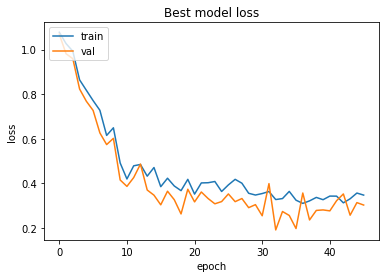

In [270]:
plt.plot(best_model_history['loss'], label='train')
plt.plot(best_model_history['val_loss'], label='val')
plt.title('Best model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper left')
plt.show()

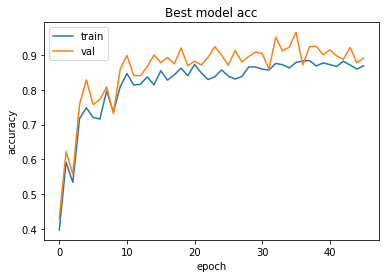

In [271]:
plt.plot(best_model_history['acc'], label='train')
plt.plot(best_model_history['val_acc'], label='val')
plt.title('Best model acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='upper left')
plt.show()

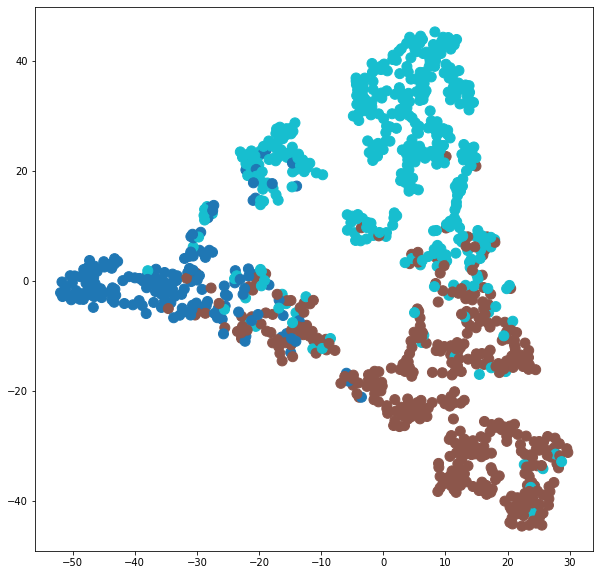

In [272]:
def plot_embedding2D(h, color=data.y, size=100):
    h = h.detach().numpy()
    h = TSNE(n_components=2, perplexity=30, n_iter=1000, verbose=False).fit_transform(h)
    fig = plt.figure(figsize=(10, 10))
    plt.set_cmap("tab10")
    plt.scatter(h[:, 0], h[:, 1], c=color, s=size)
    plt.show()

# Embedding after training
embedding = model(data.x, data.edge_index)
plot_embedding2D(embedding[data.test_mask], color=data.y[data.test_mask])